# Composite Sections

This example demonstrates how to *concreteproperties* can be used to analyse composite sections. We start by importing the necessary modules.


In [1]:
import numpy as np
from concreteproperties.material import Concrete, Steel, SteelBar
import concreteproperties.stress_strain_profile as ssp
import sectionproperties.pre.library.primitive_sections as sp_ps
import sectionproperties.pre.library.steel_sections as sp_ss
import sectionproperties.pre.library.concrete_sections as sp_cs
import concreteproperties.pre as cp_pre
from concreteproperties.concrete_section import ConcreteSection
import concreteproperties.results as res

## Assign Materials
The materials used in this example will be 50 MPa concrete with 500 MPa reinforcing steel and 300 MPa structural steel.

In [2]:
concrete = Concrete(
    name="50 MPa Concrete",
    density=2.4e-6,
    stress_strain_profile=ssp.ConcreteLinearNoTension(
        elastic_modulus=34.8e3,
        ultimate_strain=0.003,
        compressive_strength=0.9 * 50,
    ),
    ultimate_stress_strain_profile=ssp.RectangularStressBlock(
        compressive_strength=50,
        alpha=0.775,
        gamma=0.845,
        ultimate_strain=0.003,
    ),
    alpha_squash=0.85,
    flexural_tensile_strength=4.2,
    colour="lightgrey",
)

steel_300 = Steel(
    name="300 MPa Structural Steel",
    density=7.85e-6,
    stress_strain_profile=ssp.SteelElasticPlastic(
        yield_strength=300,
        elastic_modulus=200e3,
        fracture_strain=0.05,
    ),
    colour="tan",
)

steel_bar = SteelBar(
    name="500 MPa Steel Bar",
    density=7.85e-6,
    stress_strain_profile=ssp.SteelElasticPlastic(
        yield_strength=500,
        elastic_modulus=200e3,
        fracture_strain=0.05,
    ),
    colour="grey",
)

## Square Column with Universal Beam
First we will analyse a 500 mm x 500 mm square column with 12N20 bars and a central 310UC97 steel column.

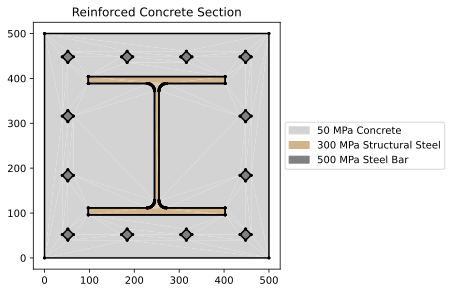

<AxesSubplot:title={'center':'Reinforced Concrete Section'}>

In [3]:
# create 500 square concrete
conc = sp_ps.rectangular_section(d=500, b=500, material=concrete)

# create 310UC97 and centre to column
uc = sp_ss.i_section(
    d=308,
    b=305,
    t_f=15.4,
    t_w=9.9,
    r=16.5,
    n_r=8,
    material=steel_300,
).align_center(align_to=conc)

# cut hole in concrete for UC then add UC
geom = conc - uc + uc

# add 12N20 reinforcing bars
geom = cp_pre.add_bar_rectangular_array(
    geometry=geom,
    area=310,
    material=steel_bar,
    n_x=4,
    x_s=132,
    n_y=4,
    y_s=132,
    anchor=(52, 52),
    exterior_only=True,
)

# create concrete section and plot
conc_sec = ConcreteSection(geom)
conc_sec.plot_section()

### Elastic Stress
Calculate the elastic stress under a bending moment of 100 kN.m.

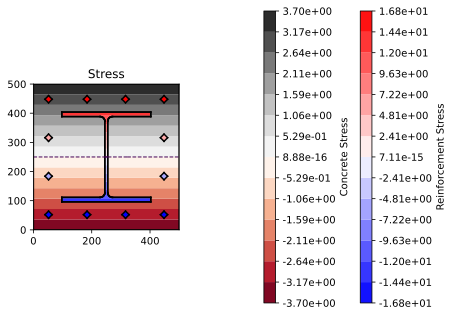

<AxesSubplot:title={'center':'Stress'}>

In [4]:
el_stress = conc_sec.calculate_uncracked_stress(m_x=100e6)
el_stress.plot_stress()

### Cracked Stress
Calculate the cracked stress under a bending moment of 500 kN.m.

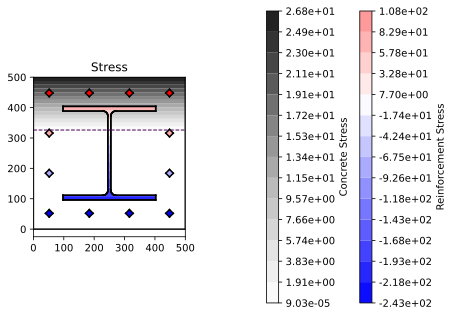

<AxesSubplot:title={'center':'Stress'}>

In [5]:
cr_res = conc_sec.calculate_cracked_properties()
cr_stress = conc_sec.calculate_cracked_stress(cracked_results=cr_res, m=500e6)
cr_stress.plot_stress()

### Moment Curvature Diagram
Generate a moment-curvature diagram and plot the stress after yielding of the steel.

In [6]:
mk_res = conc_sec.moment_curvature_analysis()

Output()

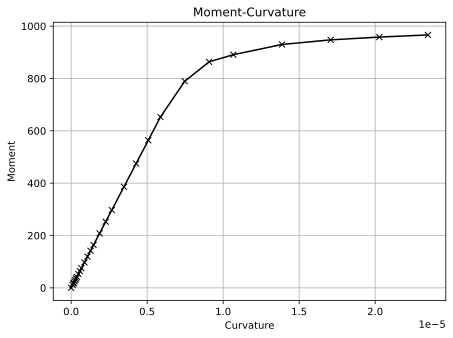

<AxesSubplot:title={'center':'Moment-Curvature'}, xlabel='Curvature', ylabel='Moment'>

In [7]:
mk_res.plot_results(fmt="kx-")

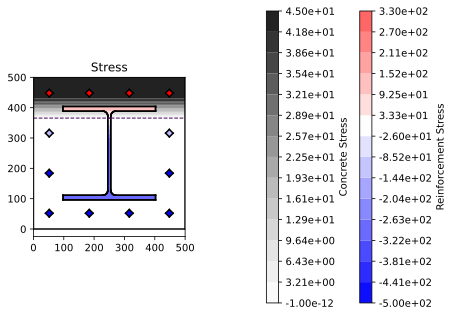

<AxesSubplot:title={'center':'Stress'}>

In [8]:
serv_stress = conc_sec.calculate_service_stress(
    moment_curvature_results=mk_res, m=None, kappa=2e-5
)
serv_stress.plot_stress()

### Ultimate Results
Finally the ultimate bending capacity about the ``x`` and ``y`` axes will be calculated, as well as generating an interaction diagram, a biaxial bending diagram and visualising the ultimate stresses.

In [9]:
ult_res_x = conc_sec.ultimate_bending_capacity()
ult_res_y = conc_sec.ultimate_bending_capacity(theta=np.pi / 2)
ult_res_x.print_results()
ult_res_y.print_results()

            Ultimate Bending Results            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Property                     ┃         Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Bending Angle - theta        │  0.000000e+00 │
│ Neutral Axis Depth - d_n     │  1.362386e+02 │
│ Neutral Axis Parameter - k_u │  3.041040e-01 │
│ Axial Force                  │ -1.865555e+01 │
│ Bending Capacity - m_x       │  9.488647e+08 │
│ Bending Capacity - m_y       │  4.363745e+05 │
│ Bending Capacity - m_xy      │  9.488648e+08 │
└──────────────────────────────┴───────────────┘

            Ultimate Bending Results            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Property                     ┃         Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Bending Angle - theta        │  1.570796e+00 │
│ Neutral Axis Depth - d_n     │  1.714567e+02 │
│ Neutral Axis Parameter - k_u │  3.827159e-01 │
│ Axial Force                  │ -2.996934e+01 │
│ Bending Capacity - m_x       │  5.681408e+05 │
│ Bending Capacity - m_y       │ -8.450024e+08 │
│ Bending Capacity - m_xy      │  8.450026e+08 │
└──────────────────────────────┴───────────────┘

Output()

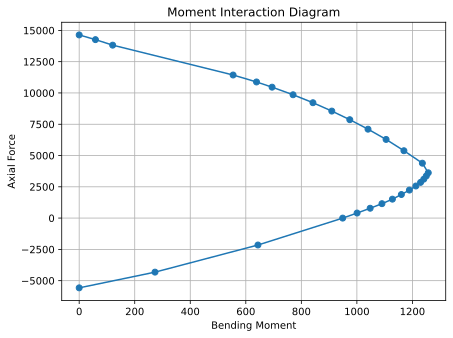

<AxesSubplot:title={'center':'Moment Interaction Diagram'}, xlabel='Bending Moment', ylabel='Axial Force'>

In [10]:
mi_res = conc_sec.moment_interaction_diagram()
mi_res.plot_diagram()

Output()

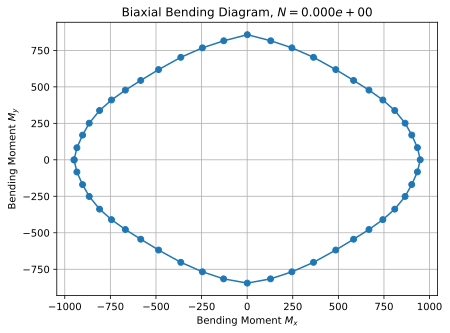

<AxesSubplot:title={'center':'Biaxial Bending Diagram, $N = 0.000e+00$'}, xlabel='Bending Moment $M_x$', ylabel='Bending Moment $M_y$'>

In [11]:
bb_res = conc_sec.biaxial_bending_diagram()
bb_res.plot_diagram()

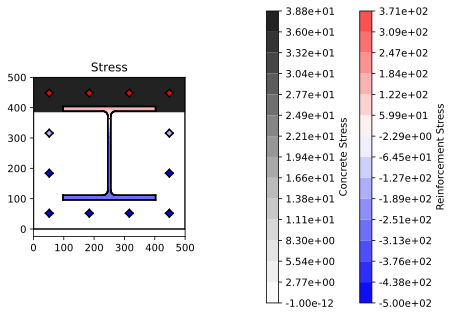

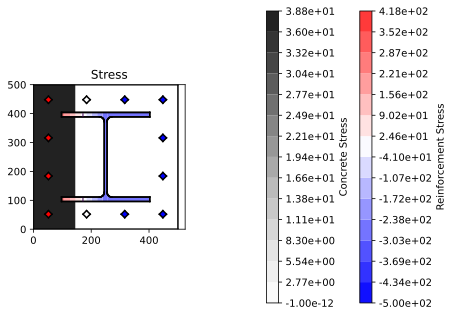

<AxesSubplot:title={'center':'Stress'}>

In [12]:
ult_stress_x = conc_sec.calculate_ultimate_stress(ult_res_x)
ult_stress_y = conc_sec.calculate_ultimate_stress(ult_res_y)
ult_stress_x.plot_stress()
ult_stress_y.plot_stress()

## Concrete Filled Steel Column
Next we will analyse a 323.9 mm x 12.7 mm steel (350 MPa) circular hollow section filled with concrete and 6N20 bars. The results will be compared to a similarly sized concrete column.

In [13]:
steel_350 = Steel(
    name="350 MPa Structural Steel",
    density=7.85e-6,
    stress_strain_profile=ssp.SteelElasticPlastic(
        yield_strength=350,
        elastic_modulus=200e3,
        fracture_strain=0.05,
    ),
    colour="tan",
)

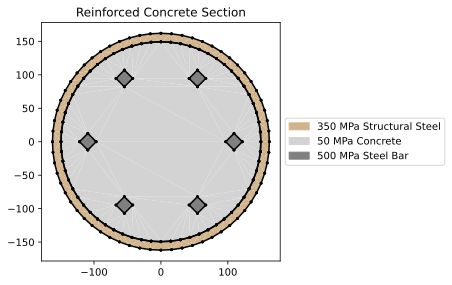

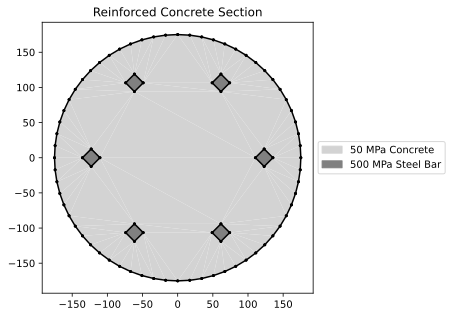

<AxesSubplot:title={'center':'Reinforced Concrete Section'}>

In [14]:
# create outer diameter of steel column
steel_col = sp_ps.circular_section_by_area(
    area=np.pi * 323.9**2 / 4,
    n=64,
    material=steel_350,
)

# create inner diameter of steel column, concrete filled
inner_conc = sp_ps.circular_section_by_area(
    area=np.pi * (323.9 - 2 * 12.7) ** 2 / 4,
    n=64,
    material=concrete,
)

# create composite geometry
geom_comp = steel_col - inner_conc + inner_conc

# add reinforcement
r_bars = 323.9 / 2 - 12.7 - 30 - 10  # 30 mm cover from inside of steel

geom_comp = cp_pre.add_bar_circular_array(
    geometry=geom_comp,
    area=310,
    material=steel_bar,
    n_bar=6,
    r_array=r_bars,
)

# create concrete section and plot
conc_sec_comp = ConcreteSection(geom_comp)
conc_sec_comp.plot_section()

# create 350 diameter column for comparison
geom_conc = sp_cs.concrete_circular_section(
    d=350,
    n=64,
    dia=20,
    n_bar=6,
    n_circle=4,
    cover=30 + 12,  # 30 mm cover + 12 mm tie
    area_conc=np.pi * 350**2 / 4,
    area_bar=310,
    conc_mat=concrete,
    steel_mat=steel_bar,
)

# create concrete section and plot
conc_sec_conc = ConcreteSection(geom_conc)
conc_sec_conc.plot_section()

### Compare Elastic Stresses
Compare the elastic stresses under a bending moment of 10 kN.m (uncracked).

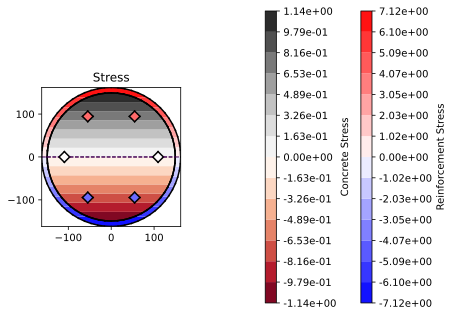

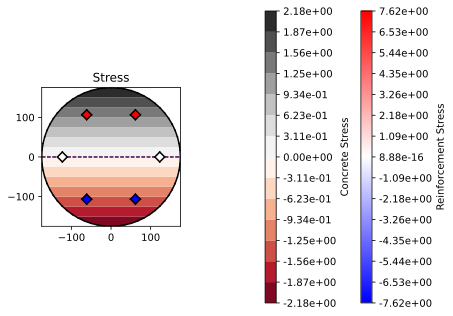

<AxesSubplot:title={'center':'Stress'}>

In [15]:
el_stress_comp = conc_sec_comp.calculate_uncracked_stress(m_x=10e6)
el_stress_conc = conc_sec_conc.calculate_uncracked_stress(m_x=10e6)
el_stress_comp.plot_stress()
el_stress_conc.plot_stress()

Compare the elastic stresses under a bending moment of 50 kN.m (cracked).

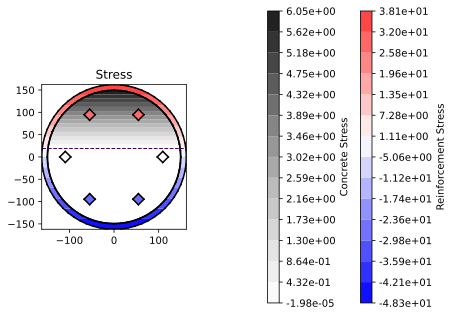

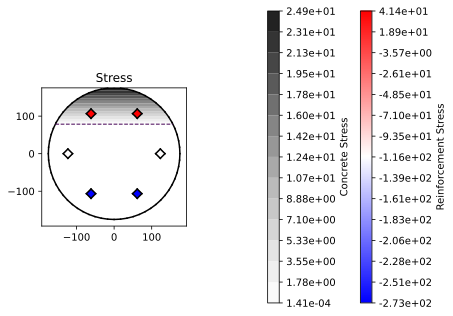

<AxesSubplot:title={'center':'Stress'}>

In [16]:
cr_res_comp = conc_sec_comp.calculate_cracked_properties()
cr_res_conc = conc_sec_conc.calculate_cracked_properties()

cr_stress_comp = conc_sec_comp.calculate_cracked_stress(
    cracked_results=cr_res_comp, m=50e6
)
cr_stress_conc = conc_sec_conc.calculate_cracked_stress(
    cracked_results=cr_res_conc, m=50e6
)
cr_stress_comp.plot_stress()
cr_stress_conc.plot_stress()

### Compare Moment Curvature Response
Calculate the moment curvature response of each column and compare the results.

In [17]:
mk_res_comp = conc_sec_comp.moment_curvature_analysis()
mk_res_conc = conc_sec_conc.moment_curvature_analysis()

Output()

Output()

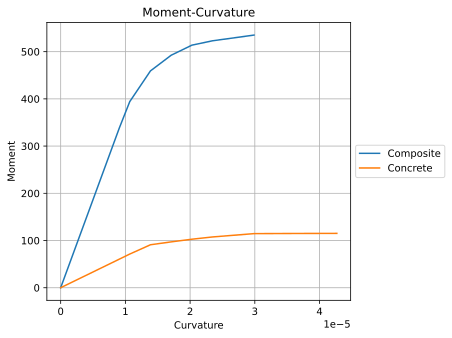

<AxesSubplot:title={'center':'Moment-Curvature'}, xlabel='Curvature', ylabel='Moment'>

In [18]:
res.MomentCurvatureResults.plot_multiple_results(
    moment_curvature_results=[mk_res_comp, mk_res_conc],
    labels=["Composite", "Concrete"],
    fmt="-",
)

Although the composite section is significantly stiffer and stronger, the regular concrete section exhibits a more ductile response due to the reduced amount of steel reinforcement.

### Compare Moment Interaction Results
Moment interaction diagrams can be produced for each section and compared. Extra points are generated on the tensile side of the composite curve to improve the fidelity of the curve.

Output()

Output()

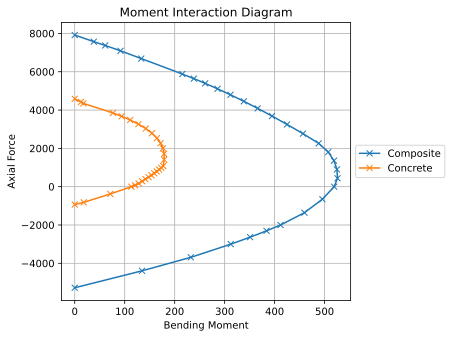

<AxesSubplot:title={'center':'Moment Interaction Diagram'}, xlabel='Bending Moment', ylabel='Axial Force'>

In [19]:
mi_res_comp = conc_sec_comp.moment_interaction_diagram(
    control_points=[
        ("kappa0", 0.0),
        ("D", 1.0),
        ("N", 0),
        ("N", -2e6),
        ("N", -3e6),
        ("d_n", 1e-06),
    ],
    n_points=[6, 16, 4, 4, 4],
)
mi_res_conc = conc_sec_conc.moment_interaction_diagram()
res.MomentInteractionResults.plot_multiple_diagrams(
    moment_interaction_results=[mi_res_comp, mi_res_conc],
    labels=["Composite", "Concrete"],
    fmt="x-",
)

## Composite Steel Beam
Finally we will analyse a steel composite beam, consisting of a 530UB92 universal beam compositely attached to a 1500 mm wide x 120 mm deep concrete slab. We start by defining the concrete material (32 MPa) for the slab.

In [20]:
concrete = Concrete(
    name="32 MPa Concrete",
    density=2.4e-6,
    stress_strain_profile=ssp.ConcreteLinearNoTension(
        elastic_modulus=30.1e3,
        ultimate_strain=0.003,
        compressive_strength=0.9 * 32,
    ),
    ultimate_stress_strain_profile=ssp.RectangularStressBlock(
        compressive_strength=32,
        alpha=0.802,
        gamma=0.89,
        ultimate_strain=0.003,
    ),
    alpha_squash=0.85,
    flexural_tensile_strength=3.4,
    colour="lightgrey",
)

Next we construct the composite geometry.

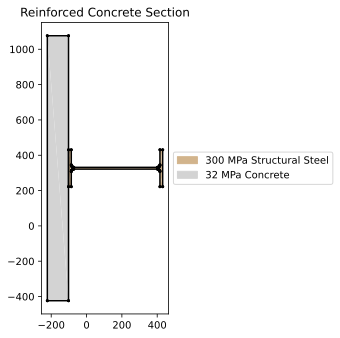

<AxesSubplot:title={'center':'Reinforced Concrete Section'}>

In [21]:
# create 530UB92
ub = sp_ss.i_section(
    d=533,
    b=209,
    t_f=15.6,
    t_w=10.2,
    r=14,
    n_r=8,
    material=steel_300,
)

# create concrete slab, centre on top of UB
conc_slab = (
    sp_ps.rectangular_section(
        d=120,
        b=1500,
        material=concrete,
    )
    .align_center(align_to=ub)
    .align_to(other=ub, on="top")
)

# as there is no overlapping geometry, we can simply add the two sections together
geom = ub + conc_slab

# the cross-section is rotated 90 degrees to aid viewing the stress plots
geom = geom.rotate_section(angle=np.pi / 2, use_radians=True)

# create concrete section and plot
conc_sec = ConcreteSection(geom)
conc_sec.plot_section()

### Moment Curvature Response
Calculate the moment curvature response of the composite section. The section should show a gradual yielding response as plasticity develops over the depth of the steel beam.

In [22]:
mk_res = conc_sec.moment_curvature_analysis(theta=np.pi / 2)

Output()

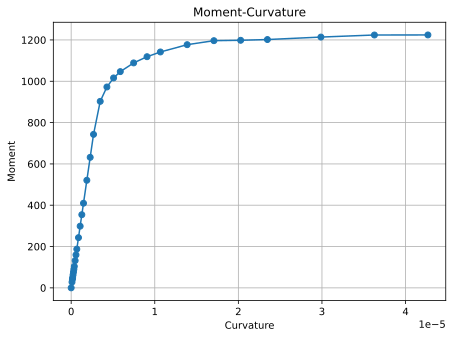

<AxesSubplot:title={'center':'Moment-Curvature'}, xlabel='Curvature', ylabel='Moment'>

In [23]:
mk_res.plot_results()

We can examine the stresses at various point within the moment-curvature response.

In [24]:
el_stress = conc_sec.calculate_service_stress(moment_curvature_results=mk_res, m=500e6)
yield_stress = conc_sec.calculate_service_stress(
    moment_curvature_results=mk_res, m=1000e6
)
ult_stress = conc_sec.calculate_service_stress(
    moment_curvature_results=mk_res, m=1200e6
)

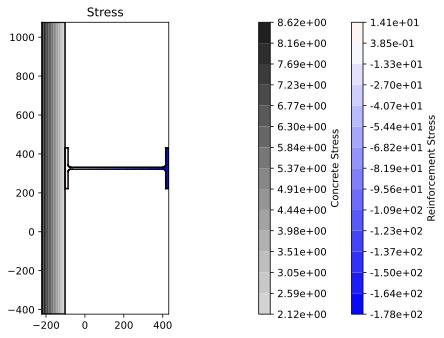

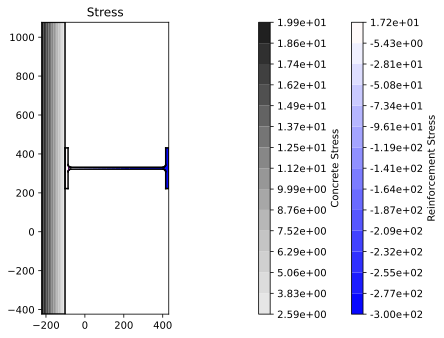

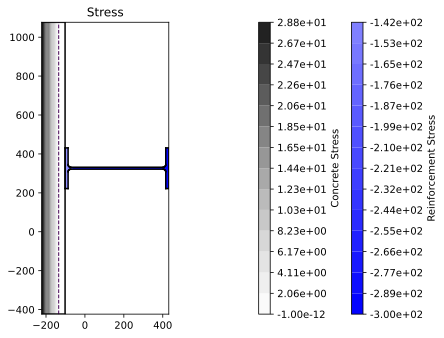

<AxesSubplot:title={'center':'Stress'}>

In [25]:
el_stress.plot_stress()
yield_stress.plot_stress()
ult_stress.plot_stress()

### Ultimate Bending Capacity
The ultimate bending capacity can be calculated and compared to the result obtained from the moment curvature analysis.

In [26]:
ult_res = conc_sec.ultimate_bending_capacity(theta=np.pi / 2)
ult_res.print_results()

            Ultimate Bending Results            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Property                     ┃         Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Bending Angle - theta        │  1.570796e+00 │
│ Neutral Axis Depth - d_n     │  9.472512e+01 │
│ Neutral Axis Parameter - k_u │  0.000000e+00 │
│ Axial Force                  │  3.399405e+01 │
│ Bending Capacity - m_x       │  3.423445e+05 │
│ Bending Capacity - m_y       │ -1.194843e+09 │
│ Bending Capacity - m_xy      │  1.194843e+09 │
└──────────────────────────────┴───────────────┘

The above results match closely with the moment curvature results, as will as confirming that the neutral axis is within the concrete slab. Note that ``k_u`` is not calculated for only meshed sections, it is only computed for lumped reinforcement.